In [95]:
import os, pickle

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import numpy as np
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
import astropy.units as u
import astropy.io.fits as fits
import astropy.io.ascii as at
from scipy.interpolate import interp1d

from hypra.utils import cat_io

home_dir = os.getenv("HOME")

Advice from Adam Kraus - fit King profiles (we're starting with Gaussians though)

In [96]:
# dbfile = '/home/martin/work/Projects/CS20hackday/Praesepe.fits'
dbfile = os.path.expanduser("~/Dropbox/data/Gaia/Praesepe_cut.fits.gz")
with fits.open(dbfile) as hdu:
    data = hdu[1].data

In [97]:
memprob = data['HDBscan_MemProb']
cluster = data['HDBscan_Cluster']
color = (data["Gaia_BP_DR2Rev"]-data["Gaia_RP_DR2Rev"])

idx = (memprob >= 0.1) &  (cluster == 1) & (color<2.5)

gaia_ra = data['gaia_dr2_source.ra'][idx]
gaia_dec = data['gaia_dr2_source.dec'][idx]

gaia_pmra = data['gaia_dr2_source.pmra'][idx]
gaia_pmdec = data['gaia_dr2_source.pmdec'][idx]

gaia_parallax = data['gaia_dr2_source.parallax'][idx]

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [125]:
center = SkyCoord(np.median(gaia_ra),np.median(gaia_dec),
                 unit=u.degree)
# center = SkyCoord("08:40:24","+19:42:00",unit=(u.hourangle,u.degree))

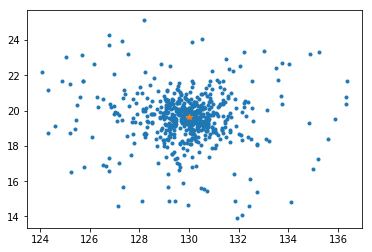

In [126]:
plt.plot(gaia_ra,gaia_dec,'.')
plt.plot(center.ra,center.dec,'*')

In [127]:
one_pc = np.tan(1/181) * u.radian
print(one_pc.to(u.arcsec),one_pc.to(u.degree))

1139.596159973264 arcsec 0.3165544888814622 deg


In [128]:
ppos = SkyCoord(gaia_ra,gaia_dec,unit=u.degree)

In [129]:
sep = ppos.separation(center)

In [130]:
sbins = np.arange(0,3600*7,one_pc.to(u.arcsec).value)

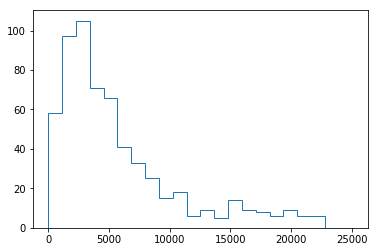

In [131]:
_ = plt.hist(sep.to(u.arcsec).value,sbins,histtype="step")

In [132]:
pc_bins = np.arange(0,15)
as_bins = np.tan(pc_bins/181) * u.radian

In [133]:
as_bins.to(u.arcsec)

<Quantity [    0.        ,  1139.59615997,  2279.26189378,  3419.06679223,
            4559.08048016,  5699.37263337,  6840.01299576,  7981.07139631,
            9122.61776631, 10264.72215646, 11407.45475412, 12550.88590066,
           13695.08610881, 14840.12608016, 15986.07672273] arcsec>

In [139]:
surf_area = np.pi * (pc_bins[1:]**2-pc_bins[:-1]**2)

In [140]:
surf_area

array([ 3.14159265,  9.42477796, 15.70796327, 21.99114858, 28.27433388,
       34.55751919, 40.8407045 , 47.1238898 , 53.40707511, 59.69026042,
       65.97344573, 72.25663103, 78.53981634, 84.82300165])

In [149]:
plt.step?

In [204]:
hist, bin_edges = np.histogram(sep.to(u.arcsec).value,
                               as_bins.to(u.arcsec).value)
hist_errs = 100*np.sqrt(hist)/hist

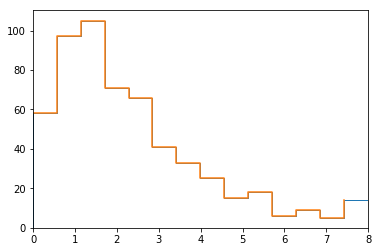

In [205]:
_ = plt.hist(sep.to(u.arcsec).value,as_bins.to(u.arcsec).value,
             histtype="step")
plt.step(bin_edges[:-1],hist,where="post")
ax = plt.gca()
ax.set_xlim(0,as_bins.to(u.arcsec).value[-1])
_ = ax.set_xticklabels(pc_bins)

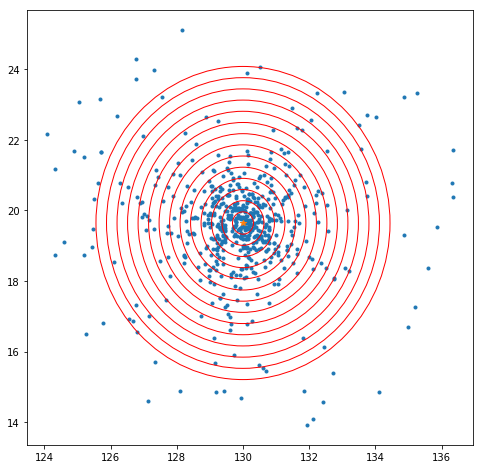

In [206]:
plt.figure(figsize=(8,8))

plt.plot(gaia_ra,gaia_dec,'.')
plt.plot(center.ra,center.dec,'*')

ax = plt.gca()
for as_bin in as_bins:
    r = as_bin.to(u.degree).value
    ring = Circle([center.ra.value,center.dec.value],radius=r,
                  color="r",zorder=100,fill=False)
    ax.add_patch(ring)
#     break

In [211]:
def gaussian(x, theta):
    mu, sig, mult = theta
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) * mult

def double_gaussian(x,theta):
    """
    Return a sum of two Gaussians, where the first
    is centered at 0
    """
    mu2,sig1,sig2,mult1,mult2 = theta
    return gaussian(x,[0,sig1,mult1]) + gaussian(x,[mu2,sig2,mult2])

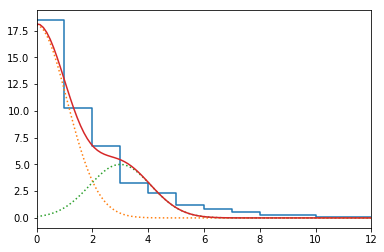

In [212]:
plt.step(pc_bins[:-1],hist/surf_area,where="post")
ax = plt.gca()
ax.set_xlim(0,12)
# _ = ax.set_xticklabels(pc_bins)
x = np.linspace(0,12,100)
y = gaussian(x,theta=[0,1.1,18])
y2 = gaussian(x,theta=[3,1.1,5])
plt.plot(x,y,ls=":")
plt.plot(x,y2,ls=":")
plt.plot(x,y+y2)

In [195]:
bin_centers = (pc_bins[1:] + pc_bins[:-1]) / 2

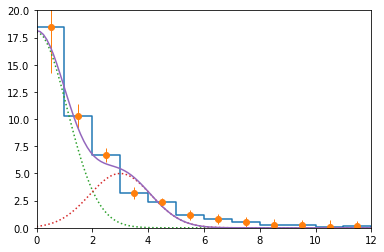

In [213]:
plt.step(pc_bins[:-1],hist/surf_area,where="post")
plt.errorbar(bin_centers,hist/surf_area,hist_errs/surf_area,fmt="o",
            linewidth=0,elinewidth=1)
ax = plt.gca()
ax.set_xlim(0,12)
ax.set_ylim(0,20)
# _ = ax.set_xticklabels(pc_bins)
x = np.linspace(0,12,100)
y = gaussian(x,theta=[0,1.1,18])
y2 = gaussian(x,theta=[3,1.1,5])
y3 = double_gaussian(x,[3,1.1,1.1,18,5])
plt.plot(x,y,ls=":")
plt.plot(x,y2,ls=":")
plt.plot(x,y3)

# Fitting

In [210]:
import emcee

In [215]:
def gauss0(x,theta):
    sig,mult = theta
    return gaussian(x,[0,sig,mult])

In [220]:
def lnlike(theta, x, y, yerr):
    model = gauss0(x,theta)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [221]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1,18], 
                     args=(bin_centers,hist/surf_area,
                           hist_errs/surf_area))
sig_ml, mult_ml = result["x"]

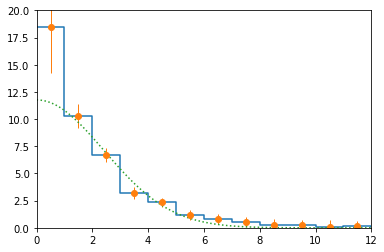

In [223]:
plt.step(pc_bins[:-1],hist/surf_area,where="post")
plt.errorbar(bin_centers,hist/surf_area,hist_errs/surf_area,fmt="o",
            linewidth=0,elinewidth=1)
ax = plt.gca()
ax.set_xlim(0,12)
ax.set_ylim(0,20)
# _ = ax.set_xticklabels(pc_bins)
x = np.linspace(0,12,100)
y = gaussian(x,theta=[0,sig_ml, mult_ml])
plt.plot(x,y,ls=":")
# plt.plot(x,y2,ls=":")
# plt.plot(x,y3)

In [234]:
def lnlike(theta, x, y, yerr):
    if theta[0]<0:
        return -np.inf
    model = double_gaussian(x,theta)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [3,1.1,1.1,18,5], 
                     args=(bin_centers,hist/surf_area,
                           hist_errs/surf_area))
mu2_ml, sig1_ml, sig2_ml, mult1_ml, mult2_ml = result["x"]

In [235]:
mu2_ml, sig1_ml, sig2_ml, mult1_ml, mult2_ml

(0.00473804381174131,
 1.6218909622076174,
 3.940209752343687,
 11.99766299500997,
 3.4018450368892186)

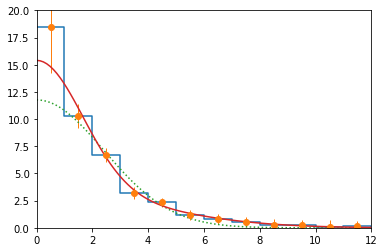

In [236]:
plt.step(pc_bins[:-1],hist/surf_area,where="post")
plt.errorbar(bin_centers,hist/surf_area,hist_errs/surf_area,fmt="o",
            linewidth=0,elinewidth=1)
ax = plt.gca()
ax.set_xlim(0,12)
ax.set_ylim(0,20)
# _ = ax.set_xticklabels(pc_bins)
x = np.linspace(0,12,100)
y = gaussian(x,theta=[0,sig_ml, mult_ml])
plt.plot(x,y,ls=":")
y = double_gaussian(x,theta=[mu2_ml, sig1_ml, sig2_ml, mult1_ml, mult2_ml])
plt.plot(x,y,ls="-")
# plt.plot(x,y2,ls=":")
# plt.plot(x,y3)

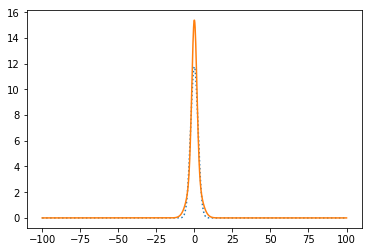

In [237]:
x = np.linspace(-100,100,1000)
y = gaussian(x,theta=[0,sig_ml, mult_ml])
plt.plot(x,y,ls=":")
y = double_gaussian(x,theta=[mu2_ml, sig1_ml, sig2_ml, mult1_ml, mult2_ml])
plt.plot(x,y,ls="-")